In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'/Users/davoodwadi/MLCourse/davoodwadi.github.io/code':
  os.chdir(r'/Users/davoodwadi/MLCourse/davoodwadi.github.io/code')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


/var/folders/jv/ppbxly7j7vzgcr8sdv78s2hr0000gn/T/ipykernel_62608/4123388575.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


{"/Users/davoodwadi/mambaforge/lib/python3.10/importlib/_bootstrap.py": 1687560475.899881, "/Users/davoodwadi/mambaforge/lib/python3.10/importlib/_bootstrap_external.py": 1687560475.905339, "/Users/davoodwadi/mambaforge/lib/python3.10/codecs.py": 1687560473.470777, "/Users/davoodwadi/mambaforge/lib/python3.10/encodings/aliases.py": 1687560474.989399, "/Users/davoodwadi/mambaforge/lib/python3.10/encodings/__init__.py": 1687560474.985129, "/Users/davoodwadi/mambaforge/lib/python3.10/encodings/utf_8.py": 1687560475.43757, "/Users/davoodwadi/mambaforge/lib/python3.10/abc.py": 1687560473.346976, "/Users/davoodwadi/mambaforge/lib/python3.10/io.py": 1687560473.627098, "/Users/davoodwadi/mambaforge/lib/python3.10/stat.py": 1687560473.825673, "/Users/davoodwadi/mambaforge/lib/python3.10/_collections_abc.py": 1687560473.307906, "/Users/davoodwadi/mambaforge/lib/python3.10/genericpath.py": 1687560473.574852, "/Users/davoodwadi/mambaforge/lib/python3.10/posixpath.py": 1687560473.717288, "/Users/da

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set random seed for reproducibility
torch.manual_seed(0)

# Generate time points
num_points = 1000
t = torch.arange(0, num_points)

# Generate sine wave
value = torch.sin(0.1*t)

# Add noise
value += 0.2*torch.randn(num_points)

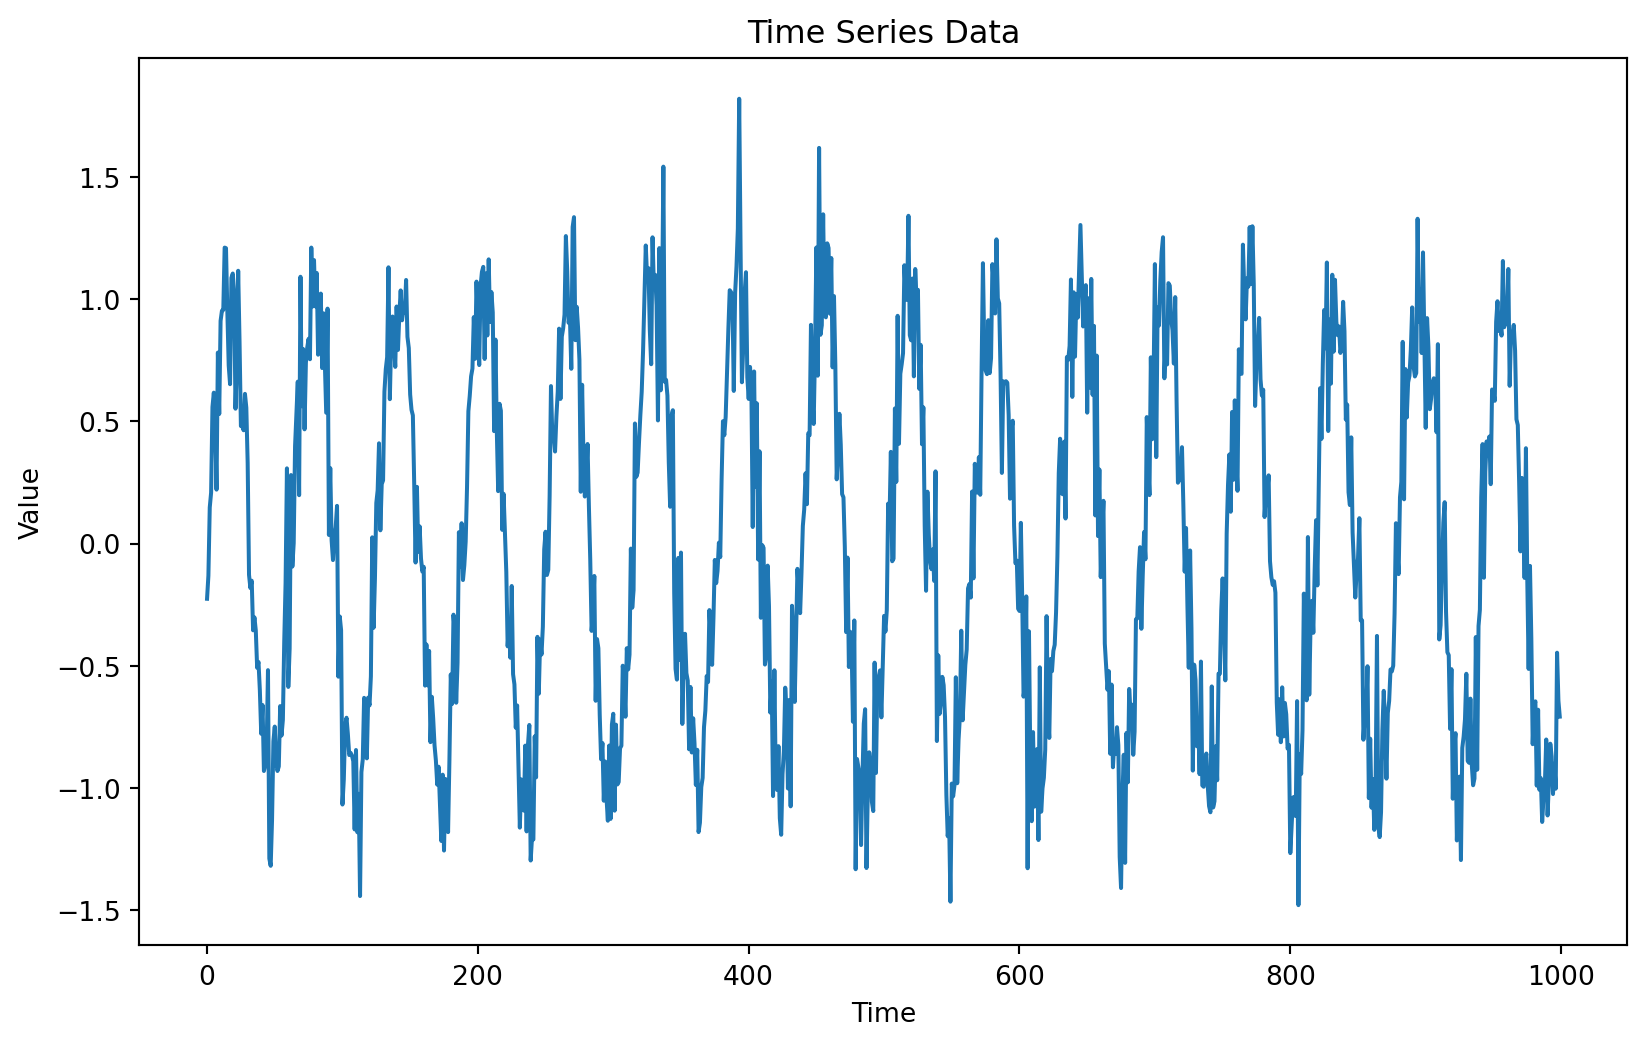

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(t, value)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()

In [5]:
# Define number of time steps for input sequence
num_steps = 10

# Split data into input and output sequences
x = []
y = []
for i in range(len(value) - num_steps):
    # creating list of x; each item has num_steps values
    x.append(value[i:i+num_steps])
    # creating list of y; each item has the next value
    y.append(value[i+num_steps])

# Convert data to PyTorch tensors
# turning list x to tensor & adding new dimension (input size) at the end
x = torch.stack(x)[..., None]
# turning list y to tensor & adding new dimension at the end
y = torch.stack(y)[..., None]

print(x.shape)
print(y.shape)

torch.Size([990, 10, 1])
torch.Size([990, 1])


In [6]:
# Define RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        # If batch_first=True, then the input and output tensors are provided as (batch, seq, feature)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        # nn.Linear to transform hidden state from hidden_size to output_size
        self.fc = nn.Linear(hidden_size, output_size)
    
    def init_h(self, x):
        '''
        To initialize the hidden state for the first iteration
        shape: d x num_layers, N, H if input is batched (our case)
        shape: d x num_layers, H if input not batched
        d: 2 if bidirectional else 1
        N: batch size
        H: hidden_size
        num_layers: number of RNN layers
        '''
        batch_size = x.shape[0]
        self.h0 = torch.zeros(1, batch_size, self.hidden_size)
        return self.h0

    def forward(self, x, hidden):
        # shape: N, L, DxH 
        # shape: 990, 10, 16
        out, hidden = self.rnn(x, hidden)
        # choose the last output of out: out[:, -1, :]
        # pass it to the fc layer
        out = self.fc(out[:, -1, :])
        return out, hidden

# Create an instance of the RNN model
input_size = 1
hidden_size = 16
output_size = 1
model = RNN(input_size, hidden_size, output_size)

In [7]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
# Set number of epochs
num_epochs = 100

# Train the model
for epoch in range(num_epochs):
    # check if it is the first epoch and initialize the hidden state
    if epoch==0: h = model.init_h(x)
    # Forward pass
    output, hidden = model(x, h)
    loss = criterion(output, y)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.1508
Epoch [20/100], Loss: 0.0804


Epoch [30/100], Loss: 0.0702
Epoch [40/100], Loss: 0.0674
Epoch [50/100], Loss: 0.0652
Epoch [60/100], Loss: 0.0632


Epoch [70/100], Loss: 0.0619


Epoch [80/100], Loss: 0.0608
Epoch [90/100], Loss: 0.0599
Epoch [100/100], Loss: 0.0590


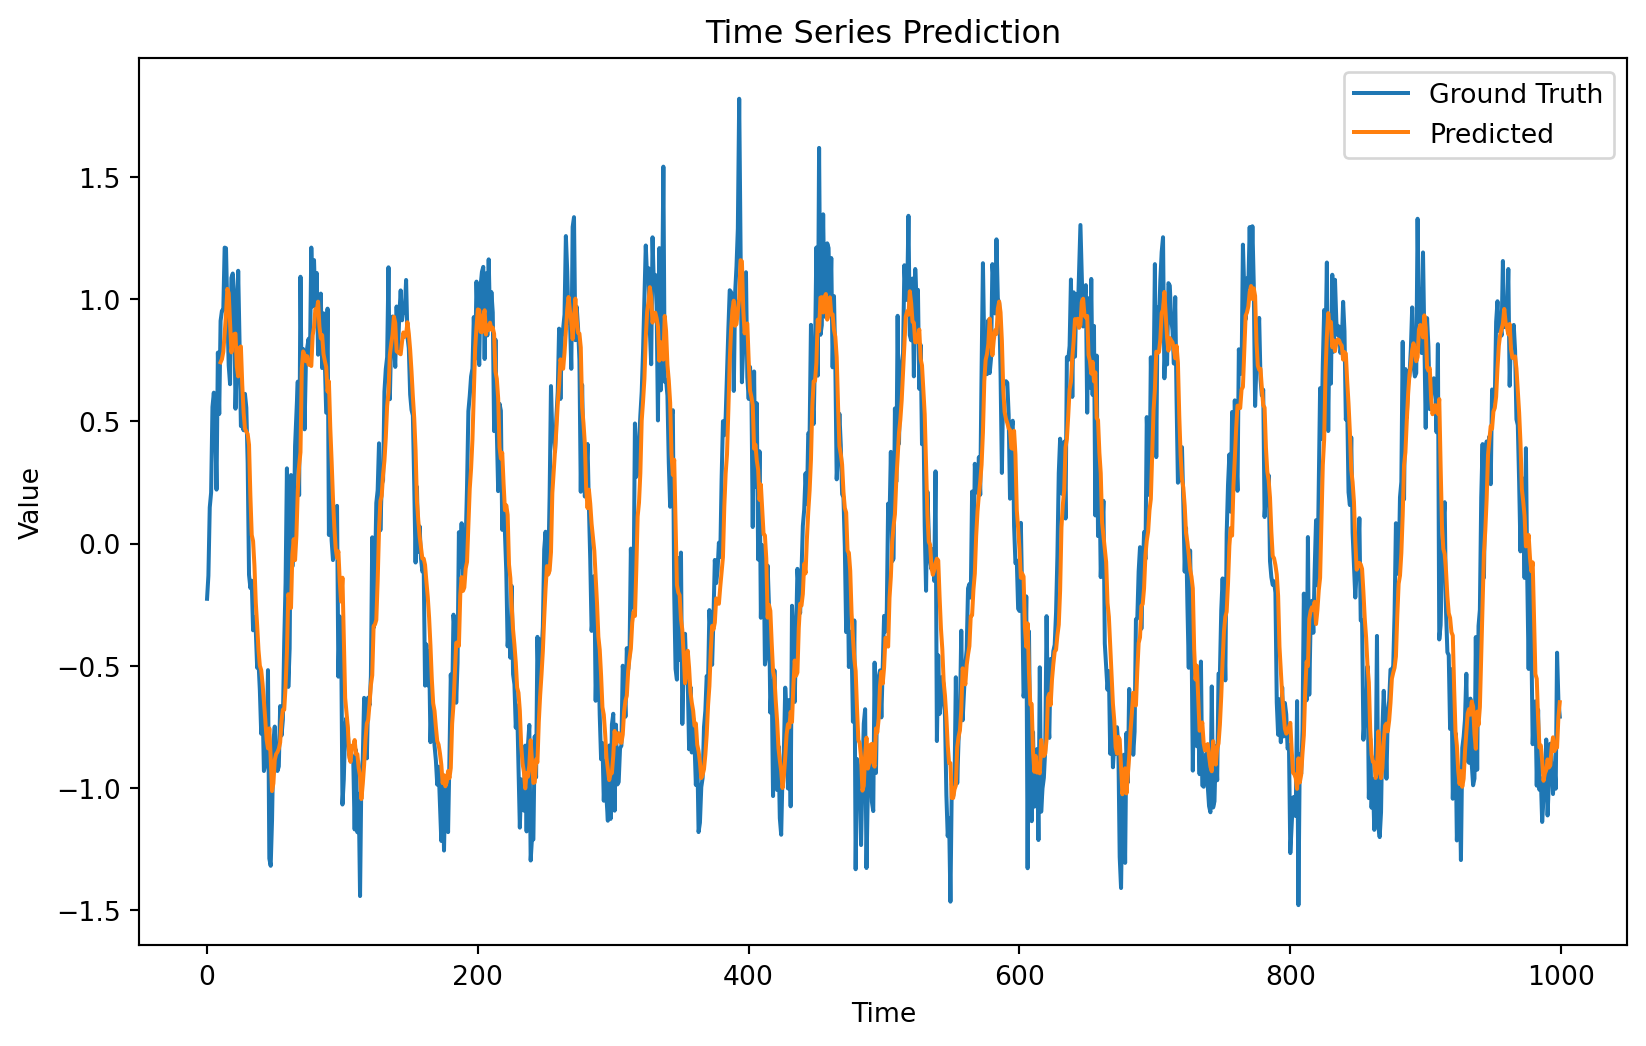

In [9]:
# Generate predictions
with torch.no_grad():
    y_pred, h = model(x, hidden)
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, value, label='Ground Truth')
plt.plot(t[num_steps:], y_pred.detach().numpy(), label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Prediction')
plt.legend()
plt.show()